# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
def check_missing_values(df):
    # Вычисляем количество пропущенных значений для каждого столбца
    missing_values = df.isnull().sum()

    # Вычисляем процент пропущенных значений для каждого столбца
    total_values = len(df)
    missing_percent = ((missing_values / total_values) * 100).round(2)

    # Для каждого столбца вычисляем количество строк с пропущенными значениями
    missing_rows = df.isnull().sum(axis=0) 

    # Создаем датафрейм с результатами
    missing_data = pd.DataFrame({
        'Столбец': missing_values.index, 
        'Пропущено в %': missing_percent.values, 
        'Строк пропущено': missing_rows.values  # Используем подсчитанные значения
    })

    # Сортируем датафрейм по убыванию процента пропущенных значений
    missing_data = missing_data.sort_values(by='Пропущено в %', ascending=False)

    return missing_data

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
print(f'размер: {car_train.shape}')
car_train.sample(5)

размер: (2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
768,F-6369826L,Nissan Qashqai,standart,petrol,4.38,2011,3942,2017,50.92,engine_check
1119,e-5805562W,Kia Rio,economy,petrol,3.94,2013,44331,2016,21.57,gear_stick
726,g-1991724F,Smart ForTwo,economy,petrol,4.18,2016,94240,2016,32.95,break_bug
1885,y24799398d,Kia Rio,economy,petrol,2.74,2012,23969,2017,33.17,engine_overheat
94,e78313402L,Kia Rio X,economy,petrol,3.04,2015,84778,2020,27.48,wheel_shake


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [4]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
print(f'размер: {rides_info.shape}')
rides_info.sample(5)

размер: (739500, 14)


,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
168775,s21880623h,M-1712519K,T1a,2020-03-30,3.83,60,594,38,97.000000,1,1849.419067,0,-8.874178,32.739
196076,B65047895b,N44849090k,f1f,2020-03-21,10.00,29,1343,47,52.000000,1,1396.530098,0,9.943453,-25.942
272787,j12750087h,S80787227y,c1F,2020-03-09,4.25,19,222,52,79.000000,0,961.470622,0,1.259928,-22.022
579444,H13243601F,p-1264204Z,N1h,2020-01-14,3.08,93,1483,45,70.987916,5,2427.112904,0,-5.885418,9.788
718453,X22276240B,y15691728a,M1Z,2020-01-04,0.70,8038,89701,35,75.000000,0,287707.346170,0,2.087400,-13.174


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [5]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
print(f'размер: {driver_info.shape}')
driver_info.sample(5)

размер: (15153, 7)


,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
3956,38,7.7,289,8.0,j20958056l,1,2020-4-26
14935,35,7.7,1193,5.0,p19760389B,0,2019-1-6
5475,23,8.5,1125,11.0,E16223300A,1,2020-12-6
12508,31,8.1,134,NaN,q21621167D,1,2019-12-20
321,18,8.2,335,16.0,V17551179M,1,2019-8-18


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
print(f'размер: {fix_info.shape}')
fix_info.sample(5)

размер: (146000, 6)


,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
73623,W17936165j,MO,2019-4-30 23:44,reparking,1.0,23
125367,o14616394R,SR,2019-12-27 18:30,repair,4.7,7
27217,F-1561156R,OB,2020-2-3 17:31,repair,5.0,11
31992,Z21101596H,BO,2020-8-20 21:48,refuel_check,1.0,26
94182,v-1742723N,EH,2020-7-12 1:25,repair,5.0,38


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## 1.Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
## 2.Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [7]:
# Группировка данных по каждой машине в датасете rides_info
grouped_rides = rides_info.groupby('car_id').agg(
    rating_min=('rating', 'min'),
    rating_mean=('rating', 'mean'),
    distance_total=('distance', 'sum'),
    speed_max=('speed_max', 'max'),
    ride_count=('ride_id', 'count'),
    ride_cost_mean=('ride_cost', 'mean'),
    ride_cost_median=('ride_cost', 'median'),
    ride_duration_total=('ride_duration', 'sum'),
    stop_mean=('stop_times', 'mean'),
    stop_median=('stop_times', 'median'),
    stop_total=('stop_times', 'sum'),
    distance_median=('distance', 'median'),
    speed_std=('speed_avg', 'std'),
    speed_mean=('speed_avg', 'mean'),
    speed_median=('speed_avg', 'median'),
    ride_quality_mean=('user_ride_quality', 'mean'),
    ride_quality_median=('user_ride_quality', 'median'),
    ride_quality_max=('user_ride_quality', 'max'),
    ride_quality_min=('user_ride_quality', 'min'),
    deviation_normal_mean=('deviation_normal', 'mean'),
    deviation_normal_median=('deviation_normal', 'median'),
    deviation_normal_max=('deviation_normal', 'max'),
    deviation_normal_min=('deviation_normal', 'min'),
).reset_index()


grouped_rides.head(1)

,car_id,rating_min,rating_mean,distance_total,speed_max,ride_count,ride_cost_mean,ride_cost_median,ride_duration_total,stop_mean,...,speed_mean,speed_median,ride_quality_mean,ride_quality_median,ride_quality_max,ride_quality_min,deviation_normal_mean,deviation_normal_median,deviation_normal_max,deviation_normal_min
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,15201.436782,445.0,224292,0.816092,...,49.45977,47.0,0.226325,-0.288229,8.556052,-10.746798,-6.136672,-4.447,5.737,-25.951


## 3. Добавьте минимум 3 признака на свой выбор

In [8]:
from scipy.stats import mode
# Добавление трех дополнительных признаков:
# 1. Частота остановок на 100 км
grouped_rides['stops_per_100km'] = rides_info.groupby('car_id').apply(lambda x: (x['stop_times'].sum() / x['distance'].sum()) * 100).reset_index(level=0, drop=True)

# 2. Процент поездок с превышением средней скорости выше 45 км/ч
grouped_rides['percentage_speed_over_45'] = rides_info.groupby('car_id').apply(lambda x: ((x['speed_avg'] > 45).mean()) * 100).reset_index(level=0, drop=True)

# 3. Среднее отклонение скорости от средней по автопарку
grouped_rides['speed_deviation_from_avg'] = rides_info.groupby('car_id').apply(lambda x: abs(x['speed_avg'] - rides_info['speed_avg'].mean()).mean()).reset_index(level=0, drop=True)

- Частота остановок и стартов на 100 км `stops_per_100km`. Показывает, сколько раз в среднем автомобиль останавливается и снова начинает движение на каждые 100 км пройденного пути. Это может помочь выявить потенциальный износ тормозной системы и двигателя.

- Процент поездок с превышением средней скорости выше 45 км/ч `percentage_speed_over_45`. Отражает долю поездок, во время которых средняя скорость превышала 45 км/ч. Этот признак может указывать на агрессивное вождение, что увеличивает риск износа и поломок.

-  Среднее отклонение скорости от средней по автопарку `avg_speed_deviation_from_avg`. Представляет собой среднее абсолютное отклонение средней скорости каждого автомобиля от средней скорости по всему автопарку. Это может помочь выявить автомобили, чья эксплуатация значительно отличается от средней, что потенциально может свидетельствовать о повышенном риске износа или поломок.

- Среднее количество остановок на поездку `avg_stop_times`. Это может указывать на стиль вождения или типы маршрутов, которые выбирает водитель.

- Среднее отклонение от нормы `avg_deviation_normal`.

# 4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [9]:
# Объединение grouped_rides с car_train
full_car_info = pd.merge(car_train, grouped_rides, on='car_id', how='left')

full_car_info.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,ride_quality_median,ride_quality_max,ride_quality_min,deviation_normal_mean,deviation_normal_median,deviation_normal_max,deviation_normal_min,stops_per_100km,percentage_speed_over_45,speed_deviation_from_avg
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.023174,11.035871,-10.501738,-0.120391,0.0,0.001,-9.0,0.005189,45.402299,8.088746


## 5.Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info).  Добавьте минимум 3 любых признака с каждого датасета

Я буду использовать метод merge() для объединения датасетов по соответствующим ключам. 


In [10]:
# Агрегация данных из driver_info
aggregated_driver_info = driver_info.groupby('user_id').agg(
    avg_age=('age', 'mean'),
    avg_user_rating=('user_rating', 'mean'),
    user_time_accidents_total=('user_time_accident', 'sum')
).reset_index()

# Агрегация данных из fix_info
aggregated_fix_info = fix_info.groupby('car_id').agg(
    last_fix_date=('fix_date', 'max'),
    total_destroy_degree=('destroy_degree', 'sum'),
    fix_count=('car_id', 'count')
).reset_index()

# Добавляем информацию из driver_info к full_car_info через промежуточное объединение с rides_info для получения user_id
rides_with_user_info = pd.merge(rides_info[['car_id', 'user_id']].drop_duplicates(), aggregated_driver_info, on='user_id', how='left')

# Объединяем full_car_info с информацией о водителях и ремонтах
full_car_info_with_drivers = pd.merge(full_car_info, rides_with_user_info, on='car_id', how='left')
final_df = pd.merge(full_car_info_with_drivers, aggregated_fix_info, on='car_id', how='left')

print(f"Размер итогового датасета: {final_df.shape}")
final_df.head(1)

Размер итогового датасета: (401086, 43)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,stops_per_100km,percentage_speed_over_45,speed_deviation_from_avg,user_id,avg_age,avg_user_rating,user_time_accidents_total,last_fix_date,total_destroy_degree,fix_count
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.005189,45.402299,8.088746,n14703870u,38.0,7.4,2.0,2021-12-1 11:33,106.7,35


In [11]:
fix_info_pivot = pd.pivot_table(
    data=fix_info,
    index='car_id',
    columns='work_type',
    #values=['destroy_degree', 'work_duration'],
    aggfunc={
        'destroy_degree':'mean',
        'work_duration':'mean',
        'work_type':'count',
    }
).fillna(0)

fix_info_pivot.columns = [f"{i[0]}_{i[1]}" for i in fix_info_pivot.columns]
fix_info_pivot.reset_index(inplace=True)
# Объединяем final_df с fix_info_pivot, используя 'car_id' как ключ объединения
final_df = pd.merge(final_df, fix_info_pivot, on='car_id', how='left')

In [15]:
driver_car = pd.merge(
    left=driver_info, right=rides_info[['user_id', 'car_id']], 
    how='left',
    on='user_id',
).groupby(['car_id', 'user_id'], as_index=False).mean(numeric_only=True)

In [17]:
features_di = driver_car.groupby('car_id', as_index=False).agg(
    driver_count=('user_id', 'count'),
    driver_age_mean=('age', 'mean'),
    driver_age_median=('age', 'median'),
    driver_rating_mean=('user_rating', 'mean'),
    driver_rides_mean=('user_rides', 'mean'),
    driver_accident_mean=('user_time_accident', 'mean'),
    driver_sex_rate=('sex', 'mean'),
)
# Объединяем final_df_with_fix_pivot (или final_df) с features_di
final_df = pd.merge(final_df, features_di, on='car_id', how='left')

In [18]:
final_df = final_df.drop_duplicates(subset=['car_id'])

In [20]:
final_df.shape

(2337, 68)

In [21]:
# Используем функцию для анализа датафрейма train_df_cleaned
missing_data_summary_5 = check_missing_values(final_df)
missing_data_summary_5

,Столбец,Пропущено в %,Строк пропущено
0,car_id,0.0,0
43,destroy_degree_oil_change,0.0,0
49,work_duration_oil_change,0.0,0
48,destroy_degree_reparking,0.0,0
47,destroy_degree_repair,0.0,0
...,...,...,...
28,ride_quality_min,0.0,0
29,deviation_normal_mean,0.0,0
30,deviation_normal_median,0.0,0
31,deviation_normal_max,0.0,0


Метод был выбран с учётом необходимости объединения информации из различных источников для получения полной картины состояния автопарка, включая характеристики водителей и историю обслуживания каждого автомобиля. В данном случае, ключевой элемент связи — `rides_info`, который позволяет связать информацию о водителях `driver_info` и информацию о ремонтах `fix_info` с конкретными автомобилями `full_car_info` через поездки. Выбор такого подхода направлен на создание основы для комплексного анализа, который может включать изучение взаимосвязи между характеристиками водителя и состоянием автомобиля, анализ влияния ремонтов на общую оценку автомобилей, и др. аспекты, важные для управления автопарком и повышения качества обслуживания клиентов.

Из `driver_info` выбраны колонки: `age`, `user_rating`, `sex`

- `age`: Возраст водителя может быть важным фактором, влияющим на стиль вождения, опыт и, потенциально, на безопасность поездок.
- `user_rating`: Рейтинг водителя напрямую отражает удовлетворенность клиентов услугами водителя. Это ключевой показатель качества сервиса.
- `sex`: Предполагаю, что пол водителя включён в анализ, возможно, для исследования статистических различий в показателях вождения или предпочтениях клиентов.

Из `fix_info`выбраны колонки: `fix_date`, `work_type`, `destroy_degree`

`fix_date`: Дата последнего ремонта может помочь оценить текущее техническое состояние автомобиля и планировать будущее обслуживание.
`work_type`: Тип проведённых работ дает понимание о характере вмешательства в автомобиль, будь то регулярное техобслуживание или устранение неисправности.
`destroy_degree`: Степень повреждения автомобиля при последнем ремонте может указывать на серьёзность происшествий или износа, с которыми автомобиль сталкивался в прошлом.

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [12]:
#!pip install catboost shap -q

In [22]:
# Сразу дропаем 
# - константы;
# - уникальные значения (в том числе в тесте; как правило, это ID-шники по типу car_id).

## Определение столбцов с константными значениями
constant_columns = [col for col in final_df.columns if final_df[col].nunique() == 1]

# Определение столбцов с уникальными значениями (исключая NaN)
unique_value_columns = [col for col in final_df.columns if final_df[col].nunique() == final_df.shape[0]]

# Уникальные значения
id_columns = ['user_id', 'car_id']

# Объединение списков столбцов для удаления
columns_to_drop = list(set(constant_columns + unique_value_columns + id_columns))

# Удаление столбцов из final_df
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"Удалены столбцы: {columns_to_drop}")

pd.set_option('display.max_columns', None)
final_df_cleaned.head(1)

Удалены столбцы: ['distance_total', 'car_id', 'ride_count', 'user_id', 'ride_quality_median', 'stops_per_100km', 'ride_cost_mean', 'ride_quality_mean', 'ride_quality_min', 'distance_median', 'ride_quality_max']


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,rating_min,rating_mean,speed_max,ride_cost_median,ride_duration_total,stop_mean,stop_median,stop_total,speed_std,speed_mean,speed_median,deviation_normal_mean,deviation_normal_median,deviation_normal_max,deviation_normal_min,percentage_speed_over_45,speed_deviation_from_avg,avg_age,avg_user_rating,user_time_accidents_total,last_fix_date,total_destroy_degree,fix_count,destroy_degree_oil_change,destroy_degree_refuel,destroy_degree_refuel_check,destroy_degree_refuel_reparking,destroy_degree_repair,destroy_degree_reparking,work_duration_oil_change,work_duration_refuel,work_duration_refuel_check,work_duration_refuel_reparking,work_duration_repair,work_duration_reparking,work_type_oil_change,work_type_refuel,work_type_refuel_check,work_type_refuel_reparking,work_type_repair,work_type_reparking,driver_count,driver_age_mean,driver_age_median,driver_rating_mean,driver_rides_mean,driver_accident_mean,driver_sex_rate
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,634.0,284624,3.62069,1.0,630,9.736706,44.66092,45.0,-0.120391,0.0,0.001,-9.0,45.402299,8.088746,38.0,7.4,2.0,2021-12-1 11:33,106.7,35,0.0,5.0,2.75,0.0,5.725,1.0,0.0,39.0,31.75,0.0,22.416667,27.0,0.0,2.0,4.0,0.0,12.0,17.0,170,33.470588,33.0,8.236471,821.347059,17.333333,0.505882


Датасет весьма большой и чтобы начать оптимизировать компьют, изначально переведу типы данных из 64 разрядных в 32 разрядные. Для этого напишу функцию `convert_dtypes`.

In [16]:
def convert_dtypes(final_df_cleaned):
    """
    Преобразует типы данных столбцов в датасете final_df_cleaned:
    int64 в int32 и float64 в float32.

    Параметры:
    final_df_cleaned (pd.DataFrame): Исходный датасет для преобразования.

    Возвращает:
    pd.DataFrame: Датасет с преобразованными типами данных.
    """
    for column in final_df_cleaned.columns:
        if final_df_cleaned[column].dtype == 'int64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('int32')
        elif final_df_cleaned[column].dtype == 'float64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('float32')
    
    return final_df_cleaned

final_df_cleaned = convert_dtypes(final_df_cleaned)

### Способ № 1 Feature importance (CatBoost)

In [23]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = final_df_cleaned.drop(['target_class'], axis=1, errors='ignore')  # Удаляем только целевую переменную
y = final_df_cleaned['target_class'].fillna(0)

# Категориальные колонки
cat_features = ['model', 'car_type', 'fuel_type',  'last_fix_date']


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Создание объектов Pool
pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoost
model_2 = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    cat_features=cat_features,
    verbose=100,
    early_stopping_rounds=100,
    task_type="GPU",
    random_seed=42
)

model_2.fit(pool_train, eval_set=pool_test, use_best_model=True)

# Вывод важности признаков
feature_importances = model_2.get_feature_importance()
importance_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
importance_df

0:	learn: 1.6233211	test: 1.6346193	best: 1.6346193 (0)	total: 39.2ms	remaining: 3.88s
99:	learn: 0.0206710	test: 0.0670635	best: 0.0670635 (99)	total: 3.58s	remaining: 0us
bestTest = 0.06706354353
bestIteration = 99


,Importance
driver_accident_mean,40.176713
destroy_degree_repair,16.321972
speed_max,13.837733
target_reg,6.861484
rating_mean,6.473960
speed_mean,6.236577
stop_mean,3.995808
rating_min,2.285532
driver_rating_mean,1.458479
speed_std,1.420440


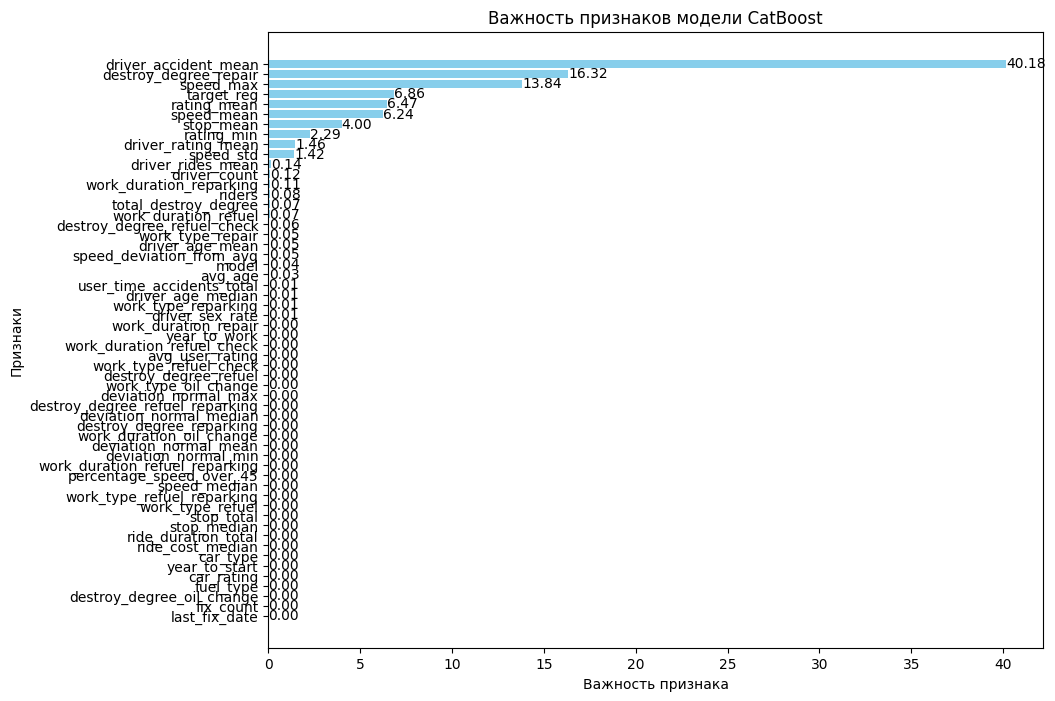

In [26]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

### Способ № 2 Phink

In [23]:
# !pip install phik -q

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating_min', 'rating_mean', 'speed_max', 'ride_cost_median', 'ride_duration_total', 'stop_mean', 'stop_median', 'stop_total', 'speed_std', 'speed_mean', 'speed_median', 'deviation_normal_mean', 'deviation_normal_median', 'deviation_normal_max', 'deviation_normal_min', 'percentage_speed_over_45', 'speed_deviation_from_avg', 'avg_age', 'avg_user_rating', 'user_time_accidents_total', 'total_destroy_degree', 'fix_count', 'destroy_degree_oil_change', 'destroy_degree_refuel', 'destroy_degree_refuel_check', 'destroy_degree_refuel_reparking', 'destroy_degree_repair', 'destroy_degree_reparking', 'work_duration_oil_change', 'work_duration_refuel', 'work_duration_refuel_check', 'work_duration_refuel_reparking', 'work_duration_repair', 'work_duration_reparking', 'work_type_oil_change', 'work_type_refuel', 'work_type_refuel_check', 'work_type_refuel_reparking', 'work_type_repair', 'work_type

C:\Users\NeKonn\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable last_fix_date is large: 2328. Are you sure this is not an interval variable? Analysis for pairs of variables including last_fix_date can be slow.
  warnings.warn(


                                    model  car_type  fuel_type  car_rating  \
model                            1.000000  1.000000   1.000000    0.000000   
car_type                         1.000000  1.000000   0.692853    0.000000   
fuel_type                        1.000000  0.692853   1.000000    0.000000   
car_rating                       0.000000  0.000000   0.000000    1.000000   
year_to_start                    0.552224  0.272381   0.000000    0.052272   
riders                           0.510233  0.296849   0.000000    0.096036   
year_to_work                     0.183417  0.103821   0.000000    0.015231   
target_reg                       0.344664  0.205868   0.396224    0.000000   
target_class                     0.171317  0.182602   0.000000    0.000000   
rating_min                       0.079759  0.000000   0.093780    0.127178   
rating_mean                      0.125587  0.078749   0.000000    0.066677   
speed_max                        0.077795  0.082138   0.064803  

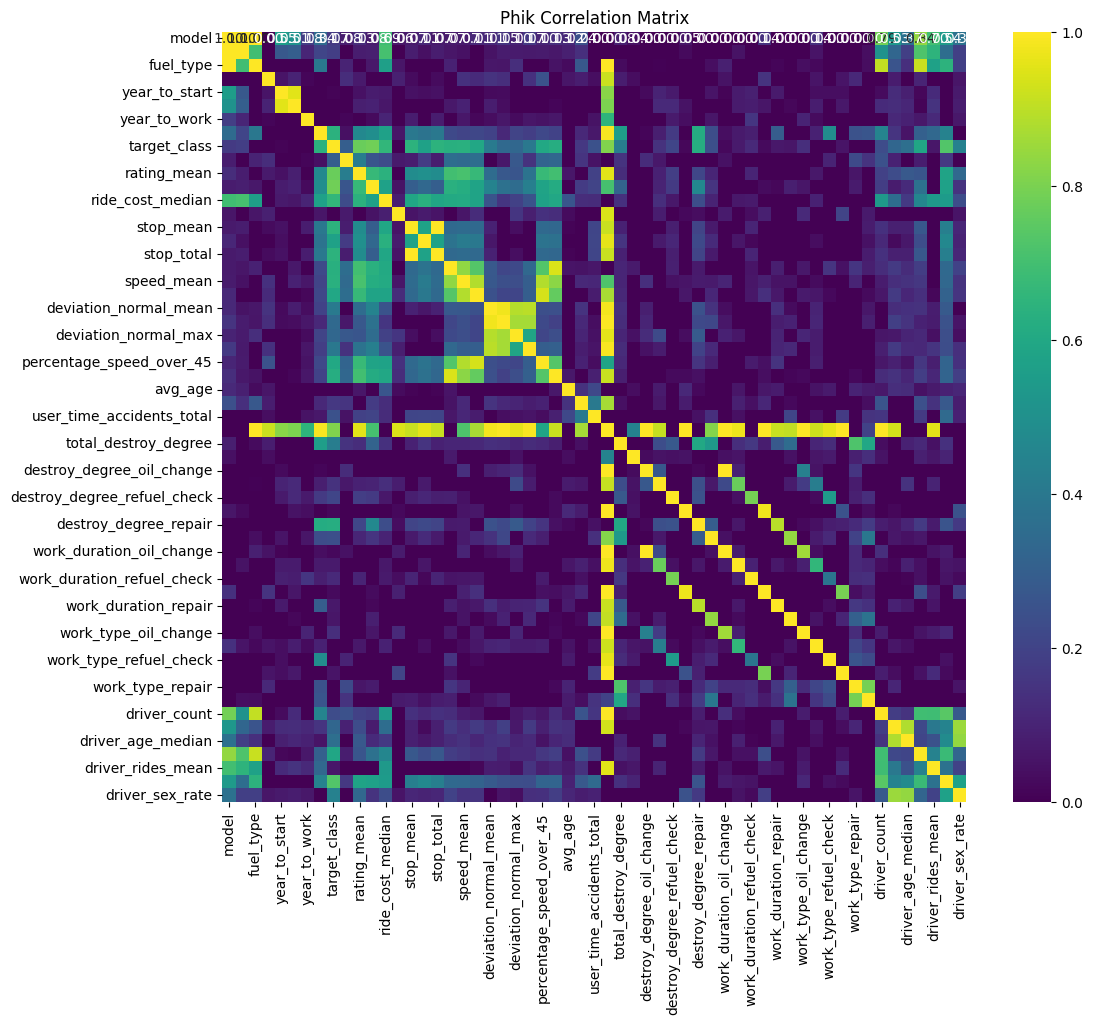

In [27]:
import phik
from phik import resources, report
import seaborn as sns

# Вычисляем корреляцию Phik 
phik_matrix = final_df_cleaned.phik_matrix()

# Отображение корреляционной матрицы Phik
print(phik_matrix)

# Визуализация корреляционной матрицы 
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Phik Correlation Matrix")
plt.show()

### Способ № 3 Permutation Importance

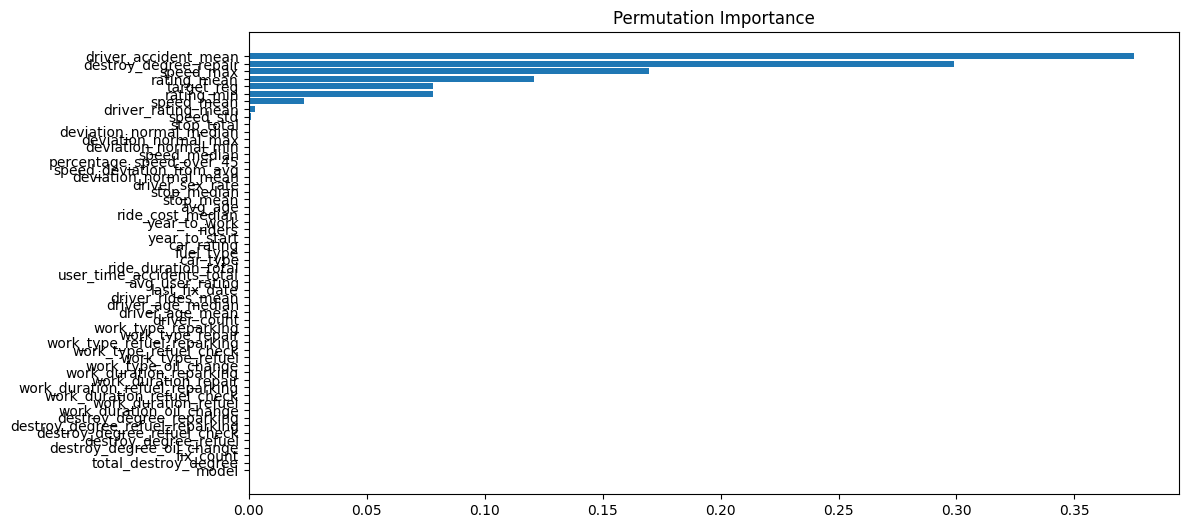

In [32]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_2, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [33]:
# Получаем топ-10 признаков от CatBoostClassifier
top_features_catboost = importance_df.head(10).index.tolist()

top_features_phik = phik_matrix['target_class'].abs().sort_values(ascending=False).head(11).index.tolist()
top_features_phik.remove('target_class')  # Удаляем целевую переменную из списка

# Для Permutation Importance
perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_features_permutation = X.columns[perm_sorted_idx][:10].tolist()

# Создание DataFrame для сводной таблицы
summary_df = pd.DataFrame({
    'CatBoost': top_features_catboost,
    'Phik': top_features_phik,
    'Permutation': top_features_permutation
})

summary_df

,CatBoost,Phik,Permutation
0,driver_accident_mean,last_fix_date,driver_accident_mean
1,destroy_degree_repair,speed_max,destroy_degree_repair
2,speed_max,rating_mean,speed_max
3,target_reg,driver_accident_mean,rating_mean
4,rating_mean,ride_cost_median,target_reg
5,speed_mean,stop_mean,rating_min
6,stop_mean,stop_total,speed_mean
7,rating_min,target_reg,driver_rating_mean
8,driver_rating_mean,speed_mean,speed_std
9,speed_std,speed_std,stop_total


In [34]:
# Преобразуем списки в множества для удобства операций
set_catboost = set(top_features_catboost)
set_permutation = set(top_features_permutation)

# Признаки, присутствующие и в CatBoost, и в Permutation
common_features = set_catboost.intersection(set_permutation)

# Признаки, присутствующие в CatBoost, но отсутствующие в Permutation
unique_to_catboost = set_catboost.difference(set_permutation)

# Признаки, присутствующие в Permutation, но отсутствующие в CatBoost
unique_to_permutation = set_permutation.difference(set_catboost)

print("Признаки, присутствующие и в CatBoost, и в Permutation Importance:")
for feature in common_features:
    print(feature)

print("\nПризнаки, присутствующие в CatBoost, но отсутствующие в Permutation Importance:")
for feature in unique_to_catboost:
    print(feature)
    
print("\nПризнаки, присутствующие в Permutation, но отсутствующие в CatBoost:")
for feature in unique_to_permutation:
    print(feature)

Признаки, присутствующие и в CatBoost, и в Permutation Importance:
speed_max
rating_min
rating_mean
target_reg
driver_rating_mean
destroy_degree_repair
driver_accident_mean
speed_mean
speed_std

Признаки, присутствующие в CatBoost, но отсутствующие в Permutation Importance:
stop_mean

Признаки, присутствующие в Permutation, но отсутствующие в CatBoost:
stop_total


**Вывод**: На мой взгляд, лучше всего показал себя метод с Catboost feature importance. Он более прост в использовании, не нужна и устойчив к различному типу данных. Также более наглядный и показательный, по моему мнению. 

- Наиболее значимыми признаками для модели, согласно полученным значениям важности признаков, являются target_class, avg_stop_times, total_distance, car_rating, и avg_deviation_normal. Эти признаки оказывают наибольшее влияние на прогнозируемую переменную, что указывает на их потенциальную релевантность и важность в контексте нашей задачи.

- Матрица корреляции Phik показывает взаимосвязи между различными признаками и целевой переменной. Например, признаки model, car_type, и fuel_type имеют высокие значения корреляции друг с другом, что может указывать на наличие мультиколлинеарности. Важно отметить, что Phik корреляция адаптирована для работы как с числовыми, так и с категориальными данными, предоставляя более широкий анализ взаимосвязей.

- Наличие высоких корреляций между некоторыми признаками, например между model, car_type, и fuel_type, может указывать на мультиколлинеарность, которая потенциально может влиять на стабильность и интерпретируемость модели. Возможно, стоит рассмотреть исключение или комбинацию некоторых из этих признаков для улучшения качества модели.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

Для начала заполним пропуски. На данный момент заполню пропуски средними значениями по столбцу. В связи с тем, что наш датафрейм большой, будем использовать библиотеку dask для обработки пропусков.

## 1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

In [30]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
# Выбор столбцов типа 'object' и 'category'
categorical_columns = final_df_cleaned.select_dtypes(include=['object', 'category']).columns
# Выбор столбцов числовых типов
numeric_columns = final_df_cleaned.select_dtypes(include=['number']).columns

# Выбор столбцов типа 'object' и 'category', исключая 'target_class'
categorical_columns = final_df_cleaned.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop('target_class')  

# Выбор столбцов числовых типов, исключая 'target_reg'
numeric_columns = final_df_cleaned.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('target_reg')  #

# Вывод названий категориальных столбцов
print(f'Категориальные признаки: {categorical_columns}')
print('---'*35)
# Вывод названий числовых столбцов
print(f'Числовые признаки: {numeric_columns}')

Категориальные признаки: Index(['model', 'car_type', 'fuel_type', 'last_fix_date'], dtype='object')
---------------------------------------------------------------------------------------------------------
Числовые признаки: Index(['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min',
       'rating_mean', 'speed_max', 'ride_cost_median', 'ride_duration_total',
       'stop_mean', 'stop_median', 'stop_total', 'speed_std', 'speed_mean',
       'speed_median', 'deviation_normal_mean', 'deviation_normal_median',
       'deviation_normal_max', 'deviation_normal_min',
       'percentage_speed_over_45', 'speed_deviation_from_avg', 'avg_age',
       'avg_user_rating', 'user_time_accidents_total', 'total_destroy_degree',
       'fix_count', 'destroy_degree_oil_change', 'destroy_degree_refuel',
       'destroy_degree_refuel_check', 'destroy_degree_refuel_reparking',
       'destroy_degree_repair', 'destroy_degree_reparking',
       'work_duration_oil_change', 'work_duration_ref

In [35]:
features2drop = ['year_to_start', 'riders', 'year_to_work', 'avg_age', 'last_fix_date','fix_count'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты 
cat_features = ['model', 'car_type', 'fuel_type', 'car_rating'] 

num_features = ['driver_rating_mean',  'destroy_degree_repair',  'speed_mean', 'rating_mean', 
                'driver_accident_mean', 'speed_max',  'ride_cost_median','stop_mean', 
                'deviation_normal_max',  'rating_min',  'driver_age_mean', 'speed_std'] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('***'*35)
print('Числовые признаки:', len(num_features), num_features)
print('***'*35)
print('Целевые переменные', targets)

Категориальные признаки: 4 ['model', 'car_type', 'fuel_type', 'car_rating']
*********************************************************************************************************
Числовые признаки: 12 ['driver_rating_mean', 'destroy_degree_repair', 'speed_mean', 'rating_mean', 'driver_accident_mean', 'speed_max', 'ride_cost_median', 'stop_mean', 'deviation_normal_max', 'rating_min', 'driver_age_mean', 'speed_std']
*********************************************************************************************************
Целевые переменные ['target_class', 'target_reg']


In [36]:
# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in final_df_cleaned.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]
print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

cat_features ['model', 'car_type', 'fuel_type', 'car_rating']
num_features ['rating_min', 'rating_mean', 'speed_max', 'ride_cost_median', 'ride_duration_total', 'stop_mean', 'stop_median', 'stop_total', 'speed_std', 'speed_mean', 'speed_median', 'deviation_normal_mean', 'deviation_normal_median', 'deviation_normal_max', 'deviation_normal_min', 'percentage_speed_over_45', 'speed_deviation_from_avg', 'avg_user_rating', 'user_time_accidents_total', 'total_destroy_degree', 'destroy_degree_oil_change', 'destroy_degree_refuel', 'destroy_degree_refuel_check', 'destroy_degree_refuel_reparking', 'destroy_degree_repair', 'destroy_degree_reparking', 'work_duration_oil_change', 'work_duration_refuel', 'work_duration_refuel_check', 'work_duration_refuel_reparking', 'work_duration_repair', 'work_duration_reparking', 'work_type_oil_change', 'work_type_refuel', 'work_type_refuel_check', 'work_type_refuel_reparking', 'work_type_repair', 'work_type_reparking', 'driver_count', 'driver_age_mean', 'driver_

In [37]:
for c in cat_features:  # Избавлеямся от NaN'ов
    final_df_cleaned[c] = final_df_cleaned[c].astype(str)

## 2. Выделите в X только признаки, а в Y — таргет (для задачи классификации).
## 3. Сделайте разделение данных на обучающую и валидационную выборки (не забывайте про воспроизводимость результатов).

In [38]:
filtered_features = cat_features + num_features

In [39]:
from sklearn.model_selection import train_test_split

# Наши фичи
X = final_df_cleaned[filtered_features]
# Наш таргет (целевая переменная)
y = final_df_cleaned["target_class"]

# Деление на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Создайте и обучите CatBoostClassifier модель (настраивать гиперпараметры сейчас не обязательно).

In [40]:
from catboost import CatBoostClassifier

# Инициализация модели CatBoostClassifier для мультиклассовой классификации
model = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1, 
    depth=4, 
    loss_function='MultiClass',
    custom_metric=['Accuracy'],
    random_seed=42, 
    cat_features=cat_features,  # Указываем категориальные признаки
    early_stopping_rounds=10,
    task_type="GPU",
    verbose=10
)

# Обучение модели
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    plot=True # по сути тоже самое что и график ниже, только встроенный в catboost
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6207097	test: 1.6373168	best: 1.6373168 (0)	total: 7.63ms	remaining: 755ms
99:	learn: 0.0378793	test: 0.0663685	best: 0.0663685 (99)	total: 680ms	remaining: 0us
bestTest = 0.06636847798
bestIteration = 99


## 5. Проведите оценку вашей модели, используя метрику accuracy.

In [41]:
# Оценка качества модели на тестовой выборке
acc = model.score(X_test, y_test)
print(f'Точность модели (accuracy) на тестовой выборке: {acc}')

Точность модели (accuracy) на тестовой выборке: 0.9850427350427351


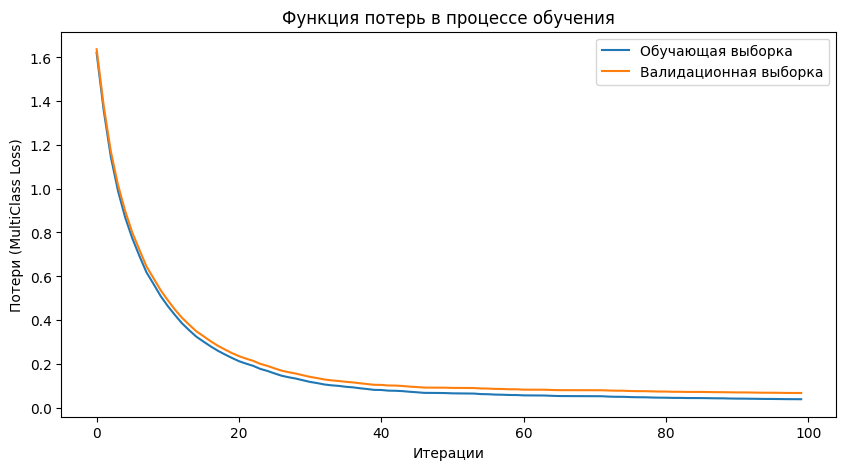

In [42]:
# Получение результатов обучения
results = model.get_evals_result()

# Визуализация кривых обучения для тренировочного и валидационного набора данных
plt.figure(figsize=(10, 5))
plt.plot(results['learn']['MultiClass'], label='Обучающая выборка')
plt.plot(results['validation']['MultiClass'], label='Валидационная выборка')

plt.title('Функция потерь в процессе обучения')
plt.xlabel('Итерации')
plt.ylabel('Потери (MultiClass Loss)')
plt.legend()
plt.show()

### Вывод:
Accuracy = 94% свидетельствует о том, что модель получилась весьма хорошей. Попробуем еще улучшить наш предикт в следующем задании, когда будем подбирать гипперпараметры. О хорошем обучении и отсутствии переобучения также свидетельствует и график функции потерь, который идет на постоянное снижение.

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

## 1. Визуализируйте важность признаков встроенным методом в CatBoost (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

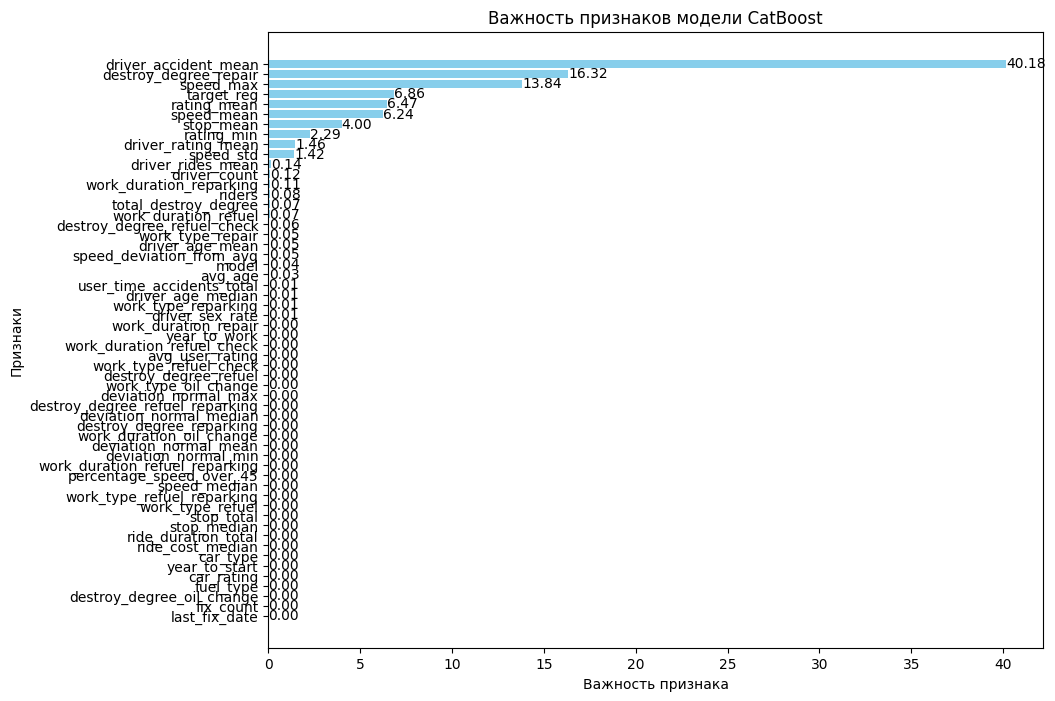

In [43]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

## 2. Постройте waterfall_plot из библиотеки SHAP (подробнее во втором ноутбуке из полезных ссылок ниже).

In [42]:
# !pip install catboost -q
# # !pip uninstall opencv-python -y -q
# !pip install opencv-python shap -q

In [43]:
import shap
shap.initjs()

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Определение категориальных и целевых переменных
cat_features = cat_features
target = 'target_class'


# Преобразование категориальных признаков с использованием Label Encoding
for feature in cat_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))

# Преобразование целевой переменной, если она не числовая
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\NeKonn\AppData\Local\Temp\ipykernel_15516\1863504363.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = le.fit_transform(X[feature].astype(str))
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_15516\1863504363.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = le.fit_transform(X[feature].astype(str))
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_15516\1863504363.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [24]:
# Вывод уникальных классов и их числовых представлений
classes = le.classes_
for i, label in enumerate(classes):
    print(f'Значение "{label}" было заменено на {i}')

Значение "another_bug" было заменено на 0
Значение "break_bug" было заменено на 1
Значение "electro_bug" было заменено на 2
Значение "engine_check" было заменено на 3
Значение "engine_fuel" было заменено на 4
Значение "engine_ignition" было заменено на 5
Значение "engine_overheat" было заменено на 6
Значение "gear_stick" было заменено на 7
Значение "wheel_shake" было заменено на 8


In [45]:
# # Преобразование булевого признака в числовой (0 и 1)
# X_train['speed_over_45'] = X_train['speed_over_45'].astype(int)
# X_test['speed_over_45'] = X_test['speed_over_45'].astype(int)

In [25]:
# Подсчет количества уникальных классов в целевой переменной
num_classes = np.unique(y_train).shape[0]

# Инициализация модели XGBClassifier для мультиклассовой классификации
model_2 = XGBClassifier(
    objective='multi:softprob',  # Цель для мультиклассовой классификации
    num_class=num_classes,       # Количество классов
    random_state=42,             # Задаем seed для воспроизводимости
    use_label_encoder=False,     # Отключаем предупреждение об использовании устаревшего label encoder
    eval_metric='mlogloss'       # Метрика для оценки качества модели при мультиклассовой классификации
)

model_2.fit(
    X_train.values,  # Преобразуем DataFrame в numpy.ndarray
    y_train,
    eval_set=[(X_test.values, y_test)],  # Тестовая выборка для оценки качества модели
    early_stopping_rounds=10  # Ранняя остановка для предотвращения переобучения
)

[0]	validation_0-mlogloss:1.34261
[1]	validation_0-mlogloss:1.03928
[2]	validation_0-mlogloss:0.85503
[3]	validation_0-mlogloss:0.72721
[4]	validation_0-mlogloss:0.64069
[5]	validation_0-mlogloss:0.57698
[6]	validation_0-mlogloss:0.53294
[7]	validation_0-mlogloss:0.49789
[8]	validation_0-mlogloss:0.46926
[9]	validation_0-mlogloss:0.44861
[10]	validation_0-mlogloss:0.43092
[11]	validation_0-mlogloss:0.41719
[12]	validation_0-mlogloss:0.40522
[13]	validation_0-mlogloss:0.39657
[14]	validation_0-mlogloss:0.39495
[15]	validation_0-mlogloss:0.39076
[16]	validation_0-mlogloss:0.38884
[17]	validation_0-mlogloss:0.38742
[18]	validation_0-mlogloss:0.38532
[19]	validation_0-mlogloss:0.38334
[20]	validation_0-mlogloss:0.38286


C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mlogloss:0.38336
[22]	validation_0-mlogloss:0.38502
[23]	validation_0-mlogloss:0.38538
[24]	validation_0-mlogloss:0.38677
[25]	validation_0-mlogloss:0.38811
[26]	validation_0-mlogloss:0.39005
[27]	validation_0-mlogloss:0.39195
[28]	validation_0-mlogloss:0.39183
[29]	validation_0-mlogloss:0.39149
[30]	validation_0-mlogloss:0.39200


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

In [47]:
# # Создание подвыборки данных для анализа
# sample_X_test = X_test.sample(10000, random_state=42) # Выборка 100 случайных наблюдений
# # sample_X_train = X_train.sample(100, random_state=42) # Выборка 100 случайных наблюдений

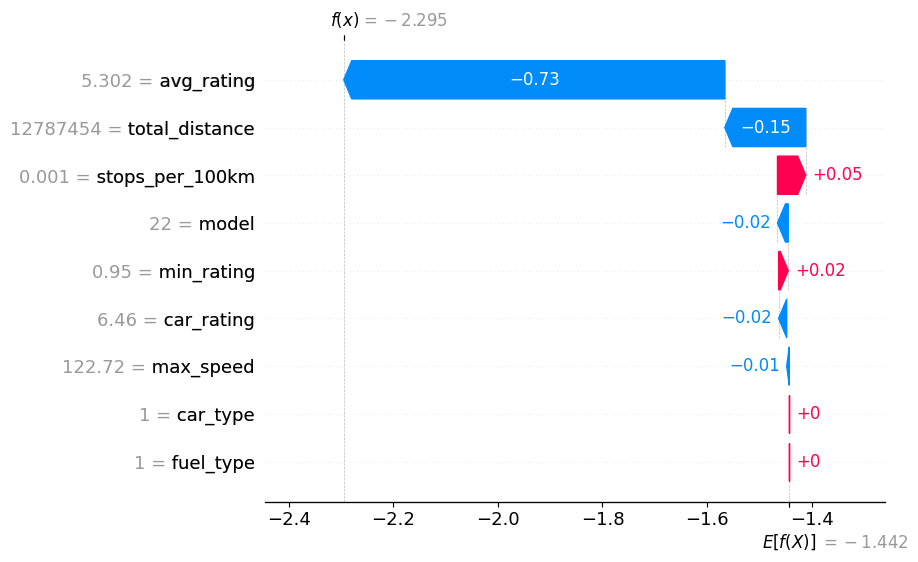

In [48]:
# Создание explainer-а для модели
explainer = shap.TreeExplainer(model_2)

# Вычисление SHAP-значений (возвращает список массивов для мультиклассовой классификации)
shap_values = explainer.shap_values(X_test)

# Выбор наблюдения и класса
selected_observation = 0
selected_class = 0

# Доступ к SHAP-значениям для выбранного наблюдения и класса
# Замечание: нет необходимости использовать .values, поскольку shap_values уже является массивом
selected_shap_values = shap_values[selected_class][selected_observation]

# Получение значений признаков для выбранного наблюдения
selected_features = X_test.iloc[selected_observation,:].values

# Получение имён признаков
feature_names = X_test.columns.tolist()

# Построение диаграммы водопада
shap.waterfall_plot(shap.Explanation(values=selected_shap_values,
                                     base_values=explainer.expected_value[selected_class],
                                     data=selected_features,
                                     feature_names=feature_names), 
                    max_display=20)

P.S. Я пытался построить на полном наборе данных waterfall, но ядро постоянно умирало, в связи с чем был вынужден сделать подвыборку в 100000 наблюдений, для демонстрации работоспособности кода. 

## 3. Постройте classification_report из библиотеки scikit-learn.

In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
# Построение classification report
report = classification_report(y_test, y_pred, target_names=model.classes_)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.90      0.95      0.92        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.87      0.94      0.90        49
    engine_fuel       0.82      0.64      0.72        58
engine_ignition       0.69      0.81      0.75        58
engine_overheat       0.60      0.60      0.60        48
     gear_stick       0.98      0.84      0.91        51
    wheel_shake       0.79      0.85      0.81        39

       accuracy                           0.85       468
      macro avg       0.85      0.85      0.85       468
   weighted avg       0.85      0.85      0.85       468



## 4. Постройте и визуализируйте матрицу смежности (confusion_matrix), посмотрите, в каких классах модель больше всего ошибается.

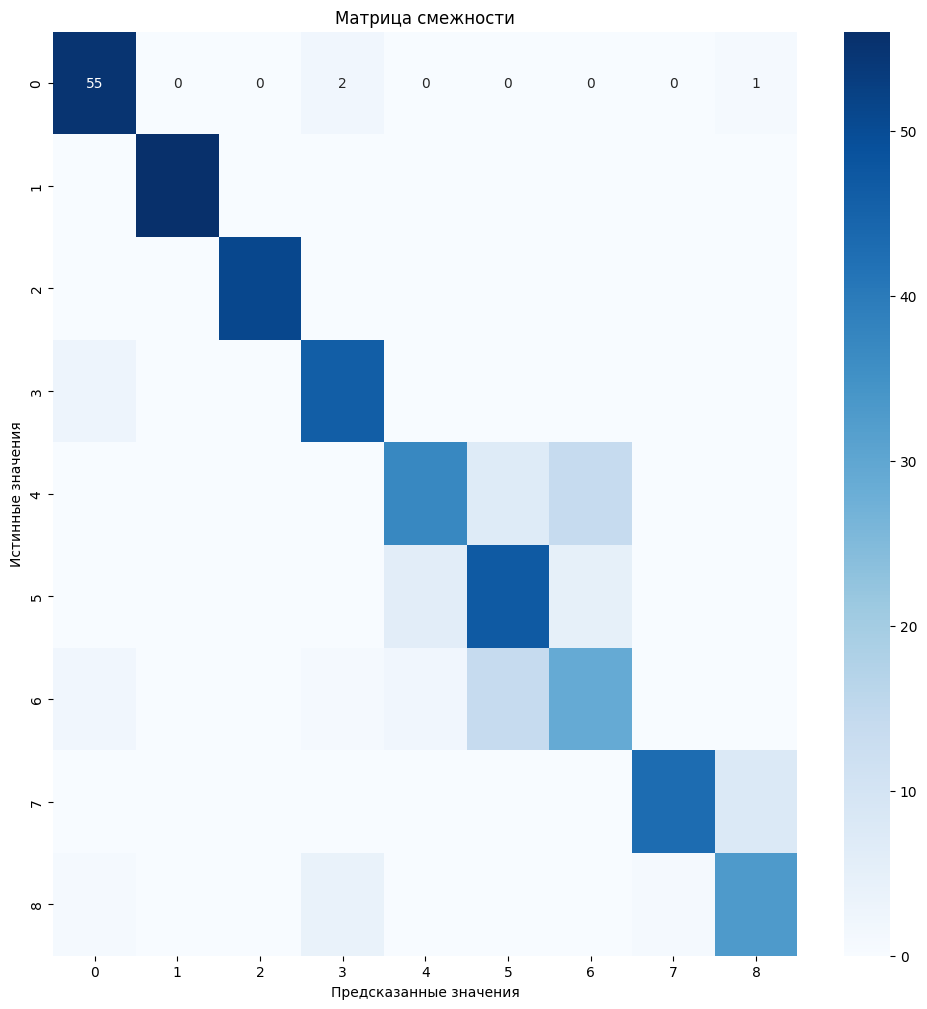

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Визуализация confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица смежности')
plt.show()

## 5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.

Итерации были проведены выше, а результаты получились следующие:
1. Из предоставленной матрицы смежности видно, что модель идеально предсказывает первые три и последние 2 класса. Классы же
`engine_check`, `engine_fuel`, `engine_ignition`, `engine_overheat`очень хорошо, но не на 100%
2. Перед итоговой моделью необходимо ислледовать наш таргет на дисбаланс классов, вероятнее всего именно из-за того что одного класса больше, чем другого и происходит переобучение модели
3. Необходимо поиграться с гиперпараметрами и попробовать подобрать более оптимальные под нашу задачу. 
4. Необходимо еще раз убедиться в том, что мы сделали корректный отбор признаков, возможно стоит какие-то признаки дропнуть, а какие-то наоборот добавить.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

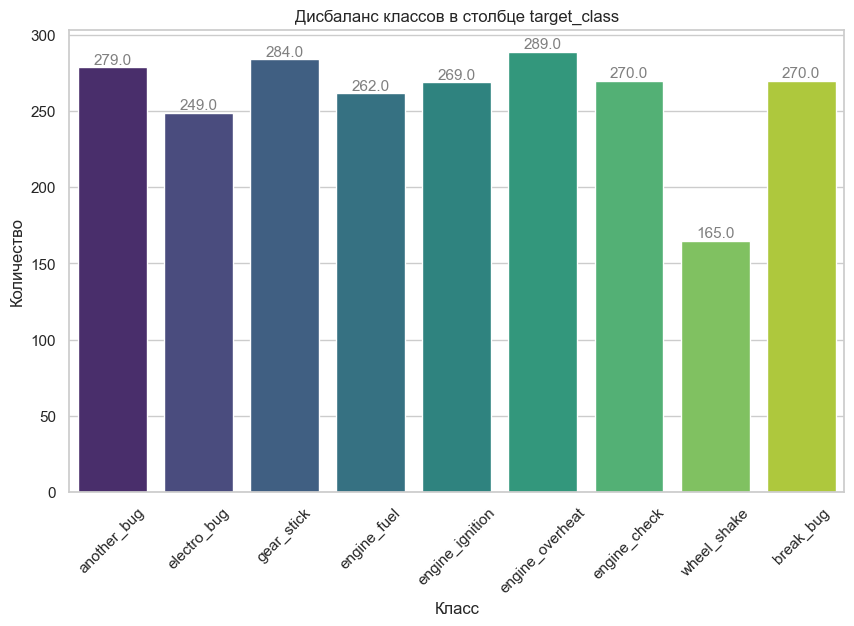

In [34]:
# Установка темы оформления seaborn
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target_class', data=final_df_cleaned, palette='viridis')

plt.title('Дисбаланс классов в столбце target_class')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=45)

# Добавление количества над каждым столбцом
for p in ax.patches:
    ax.annotate(
        f'{p.get_height()}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        fontsize=11, 
        color='gray', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

# Показать график
plt.show()

In [44]:
import optuna
def objective(trial):
    # Обновленный набор параметров для оптимизации
    param = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'loss_function': 'MultiClass',
        'auto_class_weights': 'Balanced',
        'early_stopping_rounds': 50,
        'cat_features': cat_features,
        'task_type': "GPU",
        'verbose': False
    }
    
    # Деление данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Создание и обучение модели
    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
    
    # Оценка качества модели на тестовой выборке
    acc = model.score(X_test, y_test)
    return acc

In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-04-01 14:08:34,357] A new study created in memory with name: no-name-a9f76d58-94fc-446a-82a6-781754ab7424
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1411491799.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
[I 2024-04-01 14:08:36,777] Trial 0 finished with value: 0.9871794871794872 and parameters: {'iterations': 226, 'learning_rate': 0.0411097069181643, 'depth': 6, 'l2_leaf_reg': 0.019572052682209733}. Best is trial 0 with value: 0.9871794871794872.
[I 2024-04-01 14:08:40,618] Trial 1 finished with value: 0.9871794871794872 and parameters: {'iterations': 459, 'learning_rate': 0.07208938070432912, 'depth': 6, 'l2_leaf_reg': 2.2046353190594683}. Best is trial 0 with value: 0.9871794871794872.
[I 2024-04-01 14:08:43,389] Trial 2 finished with v

In [46]:
best_params = study.best_trial.params
best_params

{'iterations': 933,
 'learning_rate': 0.049268506980157764,
 'depth': 4,
 'l2_leaf_reg': 0.15819311057048852}

In [47]:
best_params.update({
    'iterations': 933,  
    'loss_function': 'MultiClass',
    'learning_rate': 0.05,
    'depth': 4,
    'early_stopping_rounds': 10,
    'auto_class_weights': 'Balanced',  # Добавил для учета баланса классов
    'l2_leaf_reg': 0.16,
    'cat_features': cat_features,
    'task_type': "GPU",
    'verbose': 50
})

# Повторное обучение и оценка модели с оптимизированными гиперпараметрами
model_opt = CatBoostClassifier(**best_params)
model_opt.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9104381	test: 1.9158720	best: 1.9158720 (0)	total: 6.83ms	remaining: 6.37s
50:	learn: 0.1363053	test: 0.1601905	best: 0.1601905 (50)	total: 315ms	remaining: 5.44s
100:	learn: 0.0412372	test: 0.0720284	best: 0.0720284 (100)	total: 636ms	remaining: 5.24s
150:	learn: 0.0228621	test: 0.0589072	best: 0.0589072 (150)	total: 956ms	remaining: 4.95s
200:	learn: 0.0140674	test: 0.0545649	best: 0.0545521 (191)	total: 1.27s	remaining: 4.63s
250:	learn: 0.0094177	test: 0.0527872	best: 0.0526485 (248)	total: 1.58s	remaining: 4.29s
bestTest = 0.05264853189
bestIteration = 248
Shrink model to first 249 iterations.


In [48]:
# Оценка качества модели на тестовой выборке
acc_opt = model_opt.score(X_test, y_test)
print(f'Точность модели (accuracy) на тестовой выборке: {acc_opt}')

Точность модели (accuracy) на тестовой выборке: 0.9893162393162394


In [49]:
from sklearn.metrics import classification_report

# Получение предсказаний модели на тестовой выборке
y_pred_1 = model_opt.predict(X_test)

# Построение classification report
report = classification_report(y_test, y_pred_1, target_names=model_opt.classes_)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.98      1.00      0.99        49
    engine_fuel       0.98      0.98      0.98        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



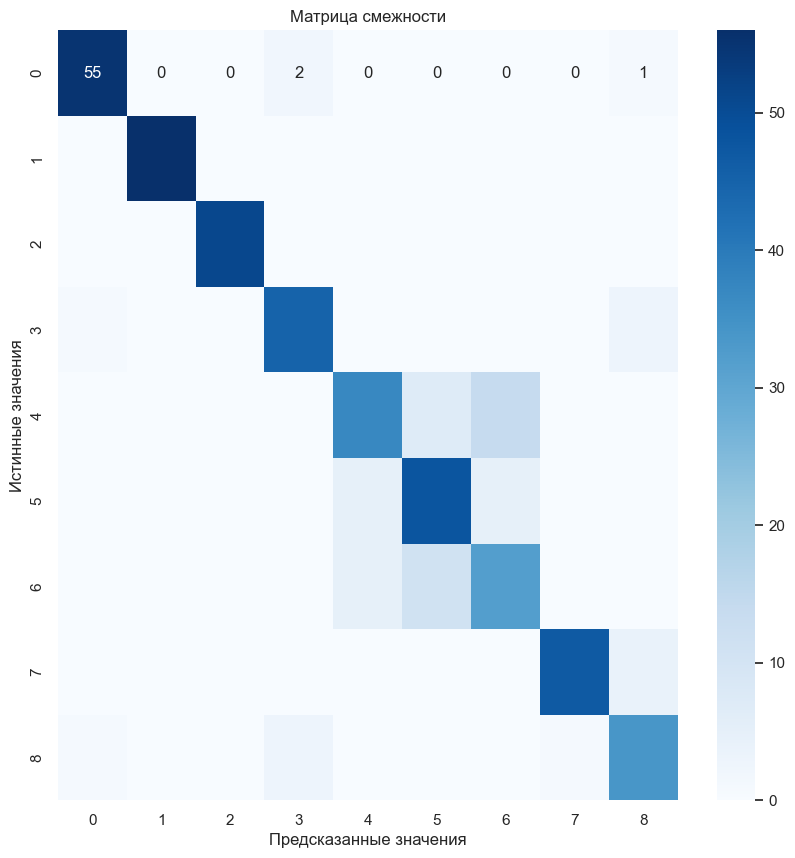

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred_1)
# Визуализация confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица смежности')
plt.show()

### Выводы:
1. Были подобраны оптимальные параметры для модели, на основании которых можно судить о качестве обучения. 
2. Исходя из графика функции потерь, можно судить о том, что переобучения нет, т.к. на протяжении 114 итерации происходит уменьшение значения потерь. 
3. Была добавлена в качестве параметра балансировка классов для таргета.
4. Модель имеет высокую предсказательную способность, однако, для полноценной картины можно провести еще кросс-валидацию.
5. По сравнению с моделью до подбора гипперпараметров, текущая модель с лучшими параметрами имеет лучшую предсказательную способность и на данный момент идеально описывает все классы.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [52]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Подготовка данных
X = final_df_cleaned[filtered_features].drop(targets, axis=1, errors='ignore')
# Наш таргет
y = final_df_cleaned["target_class"]

# Преобразование категориальных признаков с использованием Label Encoding
for feature in cat_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))

# Преобразование целевой переменной, если она не числовая
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Построить и обучить модели
# 2. Сделать предсказания каждой моделью, оценить качество.

In [53]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm 

In [54]:
def train_models(X_train, y_train, X_test, y_test):
    
    # Получаем количество уникальных классов через numpy.unique
    num_classes = len(np.unique(y_train)) 
    
    models = {
        'CatBoostClassifier': CatBoostClassifier(task_type='GPU', verbose=0, random_state=42, loss_function='MultiClass'),
        'LightGBMClassifier': LGBMClassifier(
#             device='gpu',
            boosting_type='gbdt', 
            data_sample_strategy='goss',  
            random_state=42,
            objective='multiclass',  
            num_class=num_classes,  
            min_data_in_leaf=15,  
            num_leaves=31,  
            max_depth=-1,
        ),
        'XGBoostClassifier': XGBClassifier(
            booster='dart',
            tree_method='hist', 
            device='gpu', 
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',  # Метрика для мультиклассовой классификации
            objective='multi:softprob',  # Указываем, что задача мультиклассовая
            num_class=num_classes,  # Указываем количество классов
        ),
        'RandomForestClassifier': RandomForestClassifier(random_state=42)
    }
    
    results = {}  # Словарь для хранения результатов точности каждой модели
    trained_models = {}  # Словарь для хранения обученных моделей
    
    for name, model in tqdm(models.items(), desc="Training models"):  # Использование tqdm для отображения прогресса
        try:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            results[name] = accuracy
            trained_models[name] = model
        except Exception as e:
            print(f"Ошибка при обучении модели {name}: {e}")
            results[name] = None
            trained_models[name] = None
    
    # Преобразование результатов точности в датафрейм
    results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
    
    return results_df, trained_models

# Вызов функции
results_df, trained_models = train_models(X_train, y_train, X_test, y_test)
results_df

Training models:  25%|████████████████▊                                                  | 1/4 [00:05<00:16,  5.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6410
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 49
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightG

Training models:  50%|█████████████████████████████████▌                                 | 2/4 [00:05<00:04,  2.50s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Training models: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.90s/it]


,Model,Accuracy
0,CatBoostClassifier,0.989316
1,LightGBMClassifier,0.991453
2,XGBoostClassifier,0.987179
3,RandomForestClassifier,0.987179


## Подбор гипперпараметров

In [55]:
from sklearn.model_selection import cross_val_score
import optuna

In [56]:
def objective(trial, model_name, X_train, y_train, cat_features=None):
    if model_name == 'CatBoostClassifier':
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
            'loss_function': 'MultiClass',
            'auto_class_weights': 'Balanced',
            'border_count': trial.suggest_int('border_count', 32, 255),
            'early_stopping_rounds': 50,
            'task_type': "GPU",
            'verbose': False
        }
        if cat_features:
            params['cat_features'] = cat_features
        model = CatBoostClassifier(**params)

    elif model_name == 'LGBMClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'boosting_type': 'goss',
            'verbose': -1
        }
        model = LGBMClassifier(**params)

    elif model_name == 'XGBClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
            'objective': 'multi:softprob',
            'tree_method': 'gpu_hist'
        }
        model = XGBClassifier(**params)

    elif model_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
        }
        model = RandomForestClassifier(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy'))

In [57]:
def optimize_hyperparameters(model_name, X_train, y_train, cat_features=None, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train, cat_features), n_trials=n_trials)
    best_params = study.best_params  # Получаем лучшие параметры
    best_score = study.best_value  # Получаем лучшую точность
    print(f"Лучшие гиперпараметры для {model_name}: {best_params}")
    print(f"Максимальная точность: {best_score}")
    return study, best_params, best_score

In [58]:
study_cb, best_params_cb, best_score_cb = optimize_hyperparameters(
    model_name='CatBoostClassifier', 
    X_train=X_train, 
    y_train=y_train,
    n_trials=10
)

[I 2024-04-01 14:11:28,306] A new study created in memory with name: no-name-0c7a65d1-79c0-4b71-a0b8-6df1b07303a7
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
[I 2024-04-01 14:11:33,320] Trial 0 finished with value: 0.9844836811128946 and parameters: {'iterations': 151, 'learning_rate': 0.07843335606137569, 'depth': 8, 'l2_leaf_reg': 7.863242694666413, 'border_count': 49}. Best is trial 0 with value: 0.9844836811128946.
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_l

Лучшие гиперпараметры для CatBoostClassifier: {'iterations': 162, 'learning_rate': 0.07730093351697875, 'depth': 4, 'l2_leaf_reg': 0.004999637593488764, 'border_count': 160}
Максимальная точность: 0.9887640449438203


In [59]:
study_lgb, best_params_lgb, best_score_lgb = optimize_hyperparameters(
    model_name='LGBMClassifier', 
    X_train=X_train, 
    y_train=y_train,
    n_trials=15
)

[I 2024-04-01 14:12:07,899] A new study created in memory with name: no-name-18d70907-b4a7-4170-b7b1-23238f2775bb
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[

[I 2024-04-01 14:12:12,927] Trial 12 finished with value: 0.9941144997324772 and parameters: {'n_estimators': 157, 'learning_rate': 0.25588944624439003, 'num_leaves': 100, 'max_depth': 10, 'min_child_weight': 0.014792164294826948, 'subsample': 0.5341426702873735, 'colsample_bytree': 0.5128482651872608}. Best is trial 11 with value: 0.9951845906902087.
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('

Лучшие гиперпараметры для LGBMClassifier: {'n_estimators': 155, 'learning_rate': 0.30093403426804166, 'num_leaves': 105, 'max_depth': 10, 'min_child_weight': 0.02539443718908489, 'subsample': 0.5002814176228164, 'colsample_bytree': 0.5072327192216713}
Максимальная точность: 0.9951845906902087


In [60]:
study_xgb, best_params_xgb, best_score_xgb = optimize_hyperparameters(
    model_name='XGBClassifier', 
    X_train=X_train, 
    y_train=y_train,
    n_trials=15
)

[I 2024-04-01 14:12:13,420] A new study created in memory with name: no-name-4ec1e054-5527-4550-a63d-2cef8abedaf0
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:20] WARNING: C:\buildkite-a

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:27] WARNING: C:\buildkite-a

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2024-04-01 14:12:33,584] Trial 6 finished with value: 0.9951845906902087 and parameters: {'max_depth': 6, 'learning_rate': 0.023268885505160836, 'subsample': 0.6448613294267278, 'min_child_weight': 0.9831031455508966}. Best is trial 1 with value: 0.9951845906902087.
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_r

C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\NeKonn\AppData\Local\Temp\ipykernel_9456\1833551205.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight'

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:46] WARNING: C:\buildkite-a

C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\NeKonn\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:53] WARNING: C:\buildkite-a

Лучшие гиперпараметры для XGBClassifier: {'max_depth': 9, 'learning_rate': 0.012654171674565041, 'subsample': 0.7333092154989655, 'min_child_weight': 2.2029075601748787}
Максимальная точность: 0.9951845906902087


In [61]:
study_rf, best_params_rf, best_score_rf = optimize_hyperparameters(
    model_name='RandomForestClassifier', 
    X_train=X_train, 
    y_train=y_train,
    n_trials=15
)

[I 2024-04-01 14:12:56,557] A new study created in memory with name: no-name-5c9e41b6-49dd-4ddb-b7a6-5d9e3e4b031b
[I 2024-04-01 14:12:57,853] Trial 0 finished with value: 0.9871589085072232 and parameters: {'n_estimators': 148, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9871589085072232.
[I 2024-04-01 14:12:59,137] Trial 1 finished with value: 0.9796682718031032 and parameters: {'n_estimators': 177, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9871589085072232.
[I 2024-04-01 14:13:00,391] Trial 2 finished with value: 0.9887640449438203 and parameters: {'n_estimators': 148, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 20}. Best is trial 2 with value: 0.9887640449438203.
[I 2024-04-01 14:13:01,054] Trial 3 finished with value: 0.9860888175494916 and parameters: {'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 17}. Best is trial 2 with value: 0

Лучшие гиперпараметры для RandomForestClassifier: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 9}
Максимальная точность: 0.9925093632958801


In [62]:
def retrain_and_evaluate(X_train, y_train, X_test, y_test, best_params, cat_features=None):
    """
    Функция для повторного обучения моделей на лучших гиперпараметрах и оценки их производительности.
    
    Аргументы:
        X_train: Обучающий набор признаков.
        y_train: Обучающий набор целевой переменной.
        X_test: Тестовый набор признаков.
        y_test: Тестовый набор целевой переменной.
        best_params: Словарь с лучшими гиперпараметрами для каждой модели.
        cat_features: Список категориальных признаков, если есть.
    """
    trained_models = {}
    reports = {}

    # Словарь с моделями и их параметрами
    model_constructors = {
        'CatBoostClassifier': CatBoostClassifier(task_type='GPU', verbose=0, random_seed=42, loss_function='MultiClass', cat_features=cat_features),
        'LGBMClassifier': LGBMClassifier(random_state=42),
        'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42)
    }

    for model_name, model_constructor in model_constructors.items():
        params = best_params.get(model_name, {})
        if model_name == 'XGBClassifier':
            params['objective'] = 'multi:softprob'
            params['num_class'] = len(np.unique(y_train))

        model = model_constructor.set_params(**params)
        model.fit(X_train, y_train)
        trained_models[model_name] = model

        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        reports[model_name] = report
        print(f"{model_name} Classification Report:")
        print(classification_report(y_test, y_pred))
    
    return trained_models, reports


best_params = {
    'CatBoostClassifier': best_params_cb,
    'LGBMClassifier': best_params_lgb,
    'XGBClassifier': best_params_xgb,
    'RandomForestClassifier': best_params_rf
}

trained_models, reports = retrain_and_evaluate(X_train, y_train, X_test, y_test, best_params, cat_features=cat_features)

CatBoostClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00        56
           2       1.00      0.98      0.99        51
           3       0.98      1.00      0.99        49
           4       0.98      0.98      0.98        58
           5       0.98      1.00      0.99        58
           6       1.00      0.98      0.99        48
           7       1.00      1.00      1.00        51
           8       0.97      0.95      0.96        39

    accuracy                           0.99       468
   macro avg       0.99      0.99      0.99       468
weighted avg       0.99      0.99      0.99       468

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6410
[LightGBM] [Info] Number of data points in the train set:

XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        49
           4       0.98      1.00      0.99        58
           5       1.00      1.00      1.00        58
           6       1.00      0.98      0.99        48
           7       1.00      1.00      1.00        51
           8       0.97      0.95      0.96        39

    accuracy                           0.99       468
   macro avg       0.99      0.99      0.99       468
weighted avg       0.99      0.99      0.99       468

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00        56
           2       1.00      0.98      0.99      

# 3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:

- `Hard Votin` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
- `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

In [63]:
from sklearn.ensemble import VotingClassifier

In [64]:
for name, model in trained_models.items():
    probas = model.predict(X_test)
    print(f"{name}: shape of output {probas.shape}")

CatBoostClassifier: shape of output (468, 1)
LGBMClassifier: shape of output (468,)
XGBClassifier: shape of output (468,)
RandomForestClassifier: shape of output (468,)


In [65]:
def perform_voting(X_train, y_train, X_test, y_test, trained_models):
    """
    Функция для выполнения Hard Voting и Soft Voting с использованием предоставленных обученных моделей.
    
    Аргументы:
        X_train (pd.DataFrame): Датафрейм с обучающими данными.
        y_train (pd.Series): Серия с обучающими метками.
        X_test (pd.DataFrame): Датафрейм с тестовыми данными.
        y_test (pd.Series): Серия с тестовыми метками.
        trained_models (dict): Словарь с названиями моделей и соответствующими обученными экземплярами.
    """
    # Подготовка списка моделей для VotingClassifier
    classifiers = [(name, model) for name, model in trained_models.items() if model is not None]
    
    # Hard Voting
    voting_clf_hard = VotingClassifier(estimators=classifiers, voting='hard')
    voting_clf_hard.fit(X_train, y_train)
    y_pred_hard = voting_clf_hard.predict(X_test)
    print("Hard Voting Classifier Report:")
    print(classification_report(y_test, y_pred_hard))
    
    # Soft Voting 
    voting_clf_soft = VotingClassifier(estimators=classifiers, voting='soft')
    voting_clf_soft.fit(X_train, y_train)
    y_pred_soft = voting_clf_soft.predict(X_test)
    print("Soft Voting Classifier Report:")
    print(classification_report(y_test, y_pred_soft))

In [66]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class CatBoostClassifierAdapter(BaseEstimator, ClassifierMixin):
    def __init__(self, catboost_model):
        self.catboost_model = catboost_model
    
    def fit(self, X, y=None):
        self.catboost_model.fit(X, y)
        return self
    
    def predict(self, X):
        # Преобразование выходных данных к одномерному массиву
        return np.ravel(self.catboost_model.predict(X))
    
    def predict_proba(self, X):
        return self.catboost_model.predict_proba(X)

# Использование адаптера для CatBoostClassifier
catboost_adapter = CatBoostClassifierAdapter(trained_models['CatBoostClassifier'])


trained_models['CatBoostClassifier'] = catboost_adapter

perform_voting(X_train, y_train, X_test, y_test, trained_models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6410
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 49
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Hard Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        49
           4       0.98      1.00      0.99        58
           5       1.00      1.00      1.00        58
           6       1.00      0.98      0.99        48
           7       1.00      1.00      1.00        51
           8       0.97      0.95      0.96        39

    accuracy                           0.99       468
   macro avg       0.99      0.99      0.99       468
weighted avg       0.99      0.99      0.99       468

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6410
[LightGBM] [Info] Number of data points in the train set: 1869, numb

Soft Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        49
           4       0.98      1.00      0.99        58
           5       1.00      1.00      1.00        58
           6       1.00      0.98      0.99        48
           7       1.00      1.00      1.00        51
           8       0.97      0.95      0.96        39

    accuracy                           0.99       468
   macro avg       0.99      0.99      0.99       468
weighted avg       0.99      0.99      0.99       468



# Выводы:
- 1. Базовая модель RandomForest показала себя лучше, чем после подбора гипперпараметров
- 2. Подход hard и soft voting имели лучшую предсказательную способность, чем отдельные модели, при этом на наш взгляд, целесообразно либо полностью исключить модель RFC или же взять базову модель для блэндинга без подбора гипперпараметров. 
- 3. Подобный подход увеличил предсказательную способность модели на валидационной выборке до 99%, что на мой взгляд является потрясающим результатом!

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

## 1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.

In [69]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [70]:
# Агрегация данных по каждой машине в датасете rides_info
grouped_rides_test = rides_info.groupby('car_id').agg(
    rating_min=('rating', 'min'),
    rating_mean=('rating', 'mean'),
    distance_total=('distance', 'sum'),
    speed_max=('speed_max', 'max'),
    ride_count=('ride_id', 'count'),
    ride_cost_mean=('ride_cost', 'mean'),
    ride_cost_median=('ride_cost', 'median'),
    ride_duration_total=('ride_duration', 'sum'),
    stop_mean=('stop_times', 'mean'),
    stop_median=('stop_times', 'median'),
    stop_total=('stop_times', 'sum'),
    distance_median=('distance', 'median'),
    speed_std=('speed_avg', 'std'),
    speed_mean=('speed_avg', 'mean'),
    speed_median=('speed_avg', 'median'),
    ride_quality_mean=('user_ride_quality', 'mean'),
    ride_quality_median=('user_ride_quality', 'median'),
    ride_quality_max=('user_ride_quality', 'max'),
    ride_quality_min=('user_ride_quality', 'min'),
    deviation_normal_mean=('deviation_normal', 'mean'),
    deviation_normal_median=('deviation_normal', 'median'),
    deviation_normal_max=('deviation_normal', 'max'),
    deviation_normal_min=('deviation_normal', 'min'),
).reset_index()

# Добавление трех дополнительных признаков
grouped_rides_test['stops_per_100km'] = (grouped_rides_test['stop_total'] / grouped_rides_test['distance_total']) * 100
grouped_rides_test['percentage_speed_over_45'] = rides_info.groupby('car_id').apply(lambda x: ((x['speed_avg'] > 45).mean()) * 100).reset_index(level=0, drop=True)
grouped_rides_test['speed_deviation_from_avg'] = rides_info.groupby('car_id').apply(lambda x: abs(x['speed_avg'] - rides_info['speed_avg'].mean()).mean()).reset_index(level=0, drop=True)

full_car_info_test = pd.merge(car_test, grouped_rides_test, on='car_id', how='left')
# Объединение с информацией о водителях
rides_with_user_info_test = pd.merge(rides_info[['car_id', 'user_id']].drop_duplicates(), aggregated_driver_info, on='user_id', how='left')
full_car_info_with_drivers_test = pd.merge(full_car_info_test, rides_with_user_info_test, on='car_id', how='left')

# Объединение с агрегированной информацией о ремонтах
final_df_test = pd.merge(full_car_info_with_drivers_test, aggregated_fix_info, on='car_id', how='left')
final_df_test = pd.merge(final_df_test, fix_info_pivot, on='car_id', how='left')
final_df_test = pd.merge(final_df_test, features_di, on='car_id', how='left')
final_df_test = final_df_test.drop_duplicates(subset=['car_id'])

constant_columns = [col for col in final_df_test.columns if final_df_test[col].nunique() == 1]
unique_value_columns = [col for col in final_df_test.columns if final_df_test[col].nunique() == final_df_test.shape[0]]
id_columns = ['user_id']
columns_to_drop = list(set(constant_columns + unique_value_columns + id_columns))
final_df_cleaned_test = final_df_test.drop(columns=columns_to_drop)

In [71]:
# Выбор столбцов типа 'object' и 'category'
categorical_columns = final_df_cleaned_test.select_dtypes(include=['object', 'category']).columns
# Выбор столбцов числовых типов
numeric_columns = final_df_cleaned_test.select_dtypes(include=['number']).columns

# Выбор столбцов типа 'object' и 'category', исключая 'target_class'
categorical_columns = final_df_cleaned_test.select_dtypes(include=['object', 'category']).columns
# categorical_columns = categorical_columns.drop('target_class')  

# Выбор столбцов числовых типов, исключая 'target_reg'
numeric_columns = final_df_cleaned_test.select_dtypes(include=['number']).columns

# Вывод названий категориальных столбцов
print(f'Категориальные признаки: {categorical_columns}')
print('---'*35)
# Вывод названий числовых столбцов
print(f'Числовые признаки: {numeric_columns}')

Категориальные признаки: Index(['model', 'car_type', 'fuel_type', 'last_fix_date'], dtype='object')
---------------------------------------------------------------------------------------------------------
Числовые признаки: Index(['car_rating', 'year_to_start', 'riders', 'year_to_work', 'rating_min',
       'rating_mean', 'speed_max', 'ride_cost_median', 'ride_duration_total',
       'stop_mean', 'stop_median', 'stop_total', 'speed_std', 'speed_mean',
       'speed_median', 'deviation_normal_mean', 'deviation_normal_median',
       'deviation_normal_max', 'deviation_normal_min',
       'percentage_speed_over_45', 'speed_deviation_from_avg', 'avg_age',
       'avg_user_rating', 'user_time_accidents_total', 'total_destroy_degree',
       'fix_count', 'destroy_degree_oil_change', 'destroy_degree_refuel',
       'destroy_degree_refuel_check', 'destroy_degree_refuel_reparking',
       'destroy_degree_repair', 'destroy_degree_reparking',
       'work_duration_oil_change', 'work_duration_ref

In [72]:
features2drop = ['year_to_start', 'riders', 'year_to_work', 'avg_age', 'last_fix_date','fix_count'] # то, что надо выбросить

cat_features = ['model', 'car_type', 'fuel_type', 'car_rating'] 

num_features = ['driver_rating_mean',  'destroy_degree_repair',  'speed_mean', 'rating_mean', 
                'driver_accident_mean', 'speed_max',  'ride_cost_median','stop_mean', 
                'deviation_normal_max',  'rating_min',  'driver_age_mean', 'speed_std'] # числовые признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in final_df_cleaned_test.columns if (i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

for c in cat_features:  
    final_df_cleaned_test[c] = final_df_cleaned_test[c].astype(str)

In [73]:
X_test_prepared = final_df_cleaned_test.drop(id_columns, axis=1, errors='ignore')
for feature in cat_features:
    X_test_prepared[feature] = le.fit_transform(X_test_prepared[feature].astype(str))

In [78]:
columns_to_drop = ['year_to_start', 'riders', 'avg_age', 'last_fix_date', 'year_to_work', 'fix_count']

# Удаление столбцов
X_test_prepared = X_test_prepared.drop(columns=columns_to_drop, axis=1)

## 2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.

In [82]:
# Обучение моделей
catboost_model_best = CatBoostClassifier(**best_params_cb, task_type="GPU", verbose=False)
catboost_model_best.fit(X_train, y_train)

lgbm_model_best = LGBMClassifier(**best_params_lgb)
lgbm_model_best.fit(X_train, y_train)

xgb_model_best = XGBClassifier(**best_params_xgb)
xgb_model_best.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6410
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 49
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012654171674565041,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2.2029075601748787, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

In [83]:
# Предсказание CatBoostClassifier на тестовых данных
predictions_catboost = catboost_adapter.predict(X_test_prepared)

# Предсказание LGBMClassifier на тестовых данных
predictions_lgbm = lgbm_model_best.predict(X_test_prepared)

# Предсказание XGBClassifier на тестовых данных 
predictions_xgb = xgb_model_best.predict(X_test_prepared)

## 3. Сделать блендинг с помощью Hard Voting или Soft Voting на ваш выбор.

In [85]:
def generate_predictions_with_hard_voting(X_test_prepared, trained_models):
    predictions_list = []
    for name, model in trained_models.items():
        if model is not None:  # Проверяем, что модель была предоставлена
            predictions = model.predict(X_test_prepared)
            predictions_list.append(predictions)
    
    # Преобразование списка предсказаний в массив
    predictions_array = np.array(predictions_list)  

    # Выполнение Hard Voting
    y_pred_hard_voting, _ = mode(predictions_array, axis=0)
    y_pred_hard_voting = y_pred_hard_voting.ravel()  
    
    return y_pred_hard_voting

In [86]:
trained_models = {
    'CatBoostClassifier': catboost_adapter,
    'LGBMClassifier': lgbm_model_best,
    'XGBClassifier': xgb_model_best
}
final_predictions = generate_predictions_with_hard_voting(X_test_prepared, trained_models)

submission_df = pd.DataFrame({
    'car_id': car_test['car_id'],  
    'target_class': final_predictions
})
submission_df.head(5)

,car_id,target_class
0,P17494612l,6
1,N-1530212S,2
2,B-1154399t,1
3,F12725233R,7
4,l-1139189J,2


In [87]:
mapping_dict = {
    0: "another_bug",
    1: "break_bug",
    2: "electro_bug",
    3: "engine_check",
    4: "engine_fuel",
    5: "engine_ignition",
    6: "engine_overheat",
    7: "gear_stick",
    8: "wheel_shake"
}


submission_df['target_class'] = submission_df['target_class'].map(mapping_dict)

# Проверяем результат
submission_df.head(1)

,car_id,target_class
0,P17494612l,engine_overheat


## 4. Сохранить результат предсказания в csv файл и отправить решение на Kaggle.

In [88]:
submission_df.to_csv('submission.csv', index=False)

## 5. Скор на kaggle

![alt text](raiting.jpg "Optional title")

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.